(rv)=

# Radial velocity fitting

In [1]:
import exoplanet

Fitting RVs for Earth and Jupiter

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)


# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1 #units m_earth



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278
omega_jup = np.radians(274.3)
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.304) + inclination_earth
m_jup = 317.83 #units m_earth


P_nep = 59758.97 
e_nep = 0.00859
Tper_nep = 2468662.5000000
omega_nep = np.radians(273.2)
Omega_nep = np.radians(131.784)
inclination_nep = np.radians(1.7700) + inclination_earth
m_nep = 17.204 #units m_earth5.9724



P_saturn = 10739.58 
e_saturn = 0.0539
Tper_saturn = 2452832.0625000
omega_saturn = np.radians(338.9)
Omega_saturn = np.radians(113.7)
inclination_saturn = np.radians(2.486) + inclination_earth
m_saturn = 95.159 #units m_earth




/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:291: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate_data.py:359: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


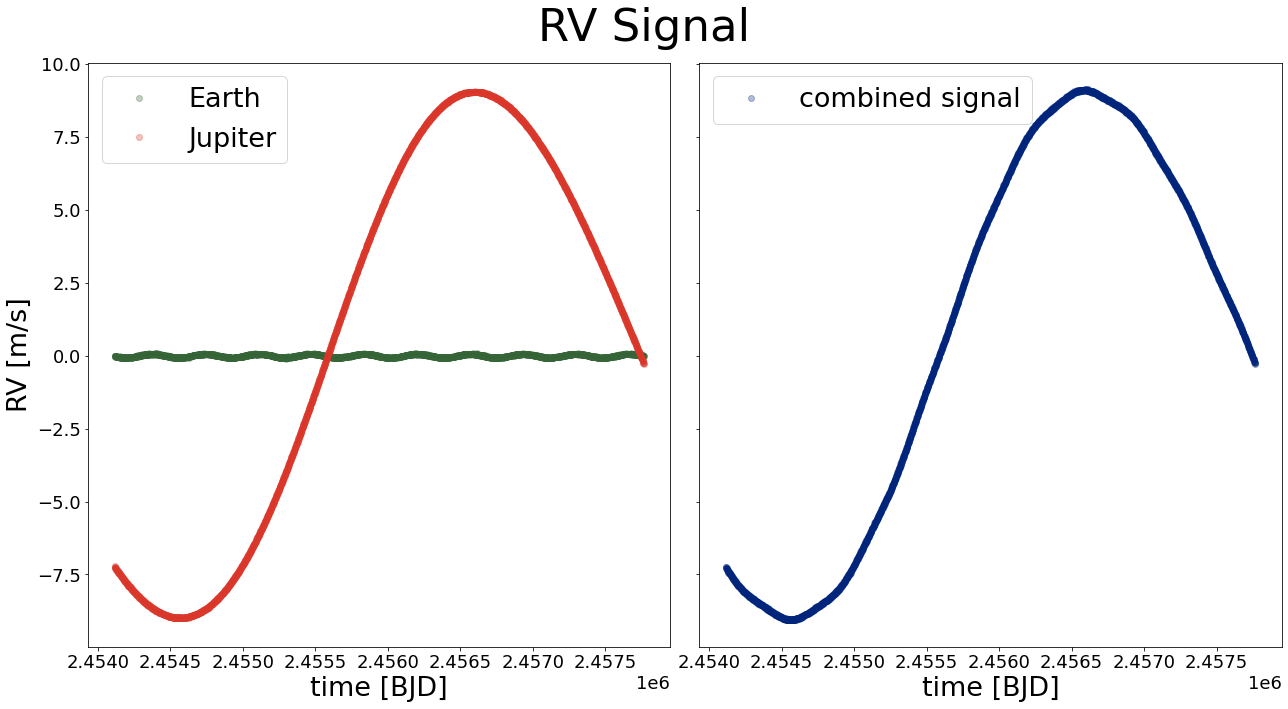

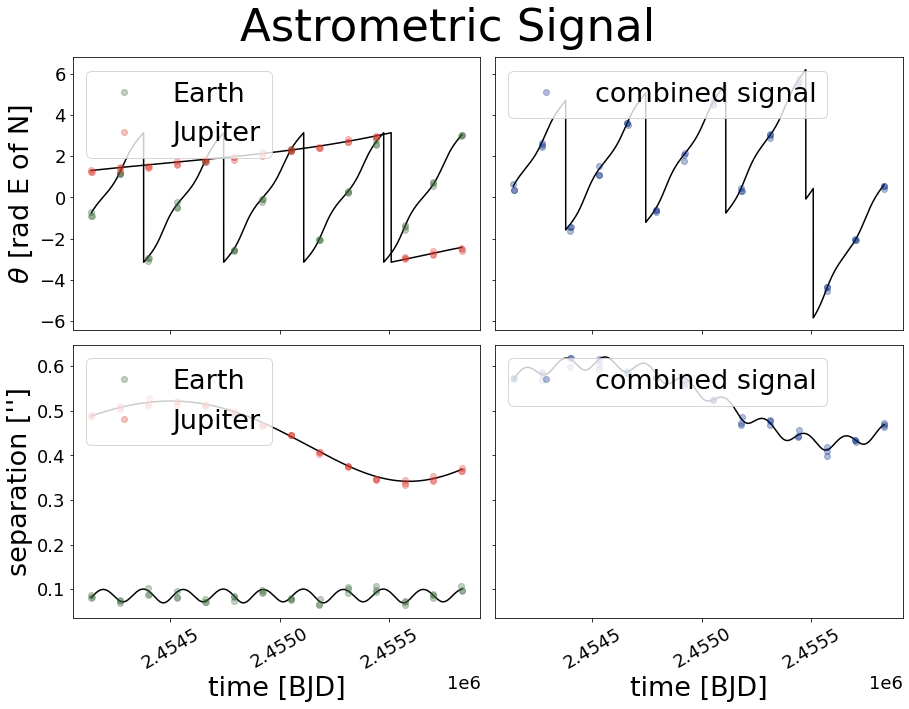

In [12]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]
orbit_params_saturn = [P_saturn, e_saturn, Tper_saturn, omega_saturn, Omega_saturn, inclination_saturn, m_saturn]
orbit_params_nep = [P_nep, e_nep, Tper_nep, omega_nep, Omega_nep, inclination_nep, m_nep]

orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1825):
    if ii % 130 == 0:
        times_observed_astrometry.append(ii-1)
        times_observed_astrometry.append(ii)
        times_observed_astrometry.append(ii+1)

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3000
sigma_rv = 0.01

sigma_theta = 0.1
sigma_rho = 0.005
plx = 0.1


simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )



<ErrorbarContainer object of 3 artists>

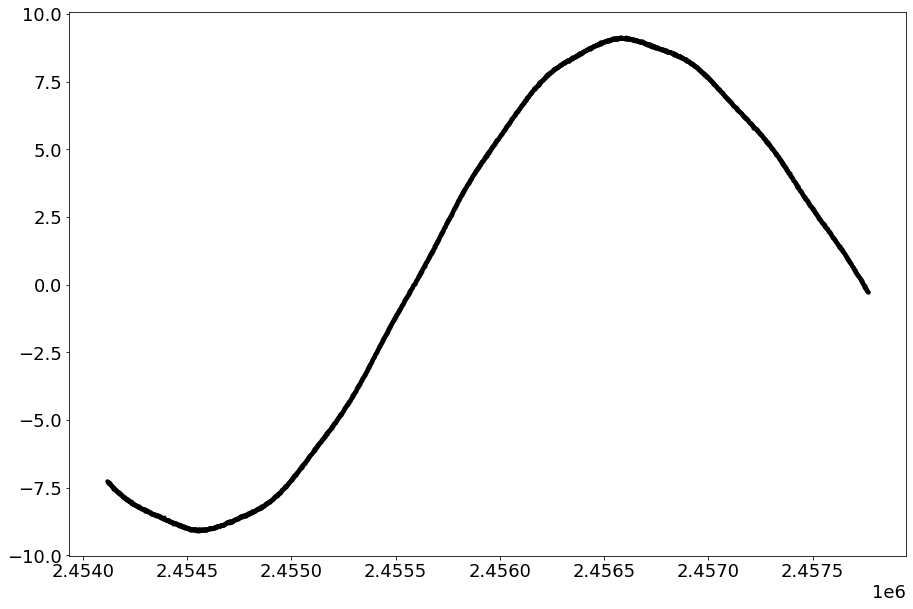

In [20]:
times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params,
    t_dur_rv = t_dur_rv,
    n_obs_rv = n_obs_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results





x_rv = times_observed_rv
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), .01)


# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


plt.figure(figsize=[15,10])
plt.errorbar(x_rv,y_rv, yerr=y_rv_err, ls = '', marker = '.', color = 'k')

We will have a sense of the periods of the planets, so we can use the `exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [21]:
periods = [365, 4327]
period_errs = [5, 5]
Ks = xo.estimate_semi_amplitude(periods, x_rv, y_rv, y_rv_err)
print(Ks, "m/s")

[0.04909861 9.09204462] m/s


In [22]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([0.01369949, 0.00115554])

In [23]:
np.array(period_errs) / np.array(periods)

array([0.01369863, 0.00115554])

## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3.
First, we'll define our priors on the parameters:

In [35]:
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:
    
    #uniform prior on t0 between initial obs time and initial obs time + period estimate
    t0 = pm.Uniform("t0", lower = x_rv[0], upper = x_rv[0]+periods, shape=2)
    
    #log normal prior on period around estimates
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape=2,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal(
        "logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    xo.eccentricity.vaneylen19(
        "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
    )

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(y_rv_err)), sd=5.0)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))

    # Define the RVs at the observed times
    rv_model = get_rv_model(x_rv)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(y_rv_err ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

Now, we can plot the initial model:

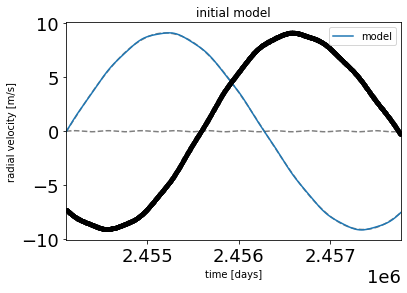

In [36]:
plt.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look good (because t0 is off) so let's fit for the maximum a posterior parameters.

In [37]:
with model:
    map_soln = pmx.optimize(start=map_soln, vars=[t0])
    map_soln = pmx.optimize(start=map_soln, vars=[logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -1089380896.0518382 -> -1089380896.0518382
optimizing logp for variables: [t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -1089380896.0518382 -> -650206.9286115939
optimizing logp for variables: [logs, logP, logK, trend]


message: Optimization terminated successfully.
logp: -650206.9286115939 -> -399.4933706710599
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -399.4933706710599 -> 1059.6583418669368
optimizing logp for variables: [trend, logs, ecs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 1059.6583418669368 -> 8597.556121427144


No handles with labels found to put in legend.


Text(0.5, 1.0, 'MAP model only')

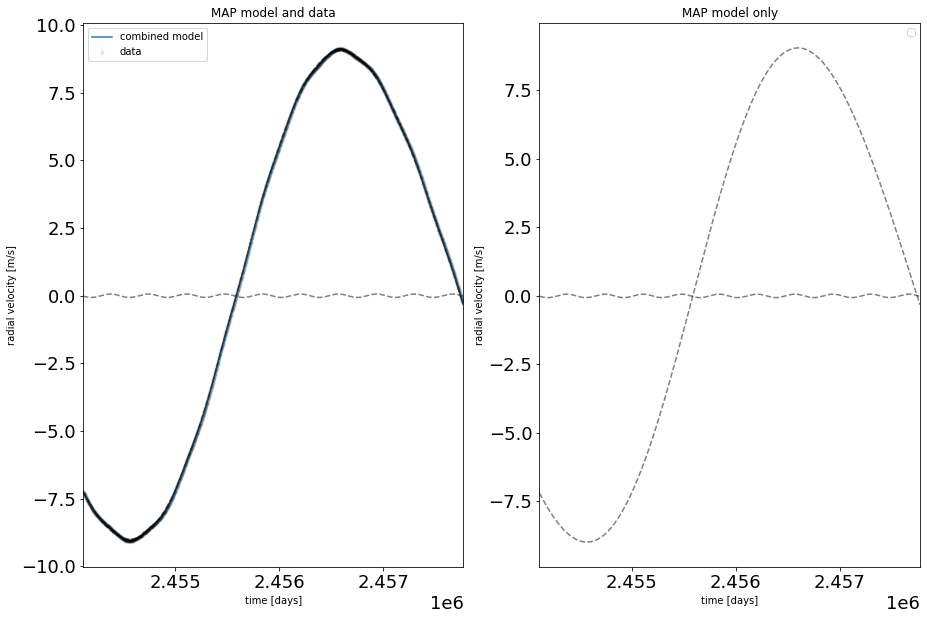

In [44]:
fig, ax = plt.subplots(1,2, figsize = [15,10])
ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data')
ax[0].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
ax[0].plot(t, map_soln["rv_model_pred"], label="combined model")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MAP model and data")


ax[1].plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
ax[1].legend(fontsize=10)
ax[1].set_xlim(t.min(), t.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")


That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use the `pmx.sample` function from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext) which wraps `pm.sample` function with some better defaults and tuning strategies.

In [45]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, ecs, logK, logP, t0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 162 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.999638201735381, but should be close to 0.9. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9996833374247099, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [46]:
import arviz as az

az.summary(
    trace, var_names=["logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.000,0.000,0.000,0.000,0.000,0.000,3.0,2.0,3.0,11.0,2.09
trend[1],-0.000,0.000,-0.000,-0.000,0.000,0.000,2.0,2.0,2.0,11.0,2.36
trend[2],0.000,0.001,-0.001,0.001,0.000,0.000,2.0,2.0,2.0,23.0,2.43
logs,-3.901,0.100,-4.112,-3.822,0.048,0.036,4.0,4.0,3.0,23.0,1.77
omega[0],0.787,0.007,0.779,0.795,0.005,0.004,2.0,2.0,2.0,23.0,2.43
omega[1],0.679,0.014,0.665,0.706,0.007,0.005,4.0,4.0,3.0,14.0,1.63
ecc[0],0.000,0.000,0.000,0.000,0.000,0.000,2.0,2.0,2.0,11.0,2.46
ecc[1],0.000,0.000,0.000,0.000,0.000,0.000,4.0,4.0,3.0,23.0,1.77
t0[0],2454298.027,0.005,2454298.021,2454298.033,0.002,0.003,11.0,2.0,2.0,11.0,2.43
t0[1],2456948.105,90.286,2456754.936,2457011.717,42.502,32.243,5.0,5.0,3.0,23.0,1.89


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

In [47]:
import corner

with model:
    _ = corner.corner(trace, var_names=["P", "logK", "ecc", "omega"])

ValueError: It looks like the parameter(s) in column(s) 0 have no dynamic range. Please provide a `range` argument.

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

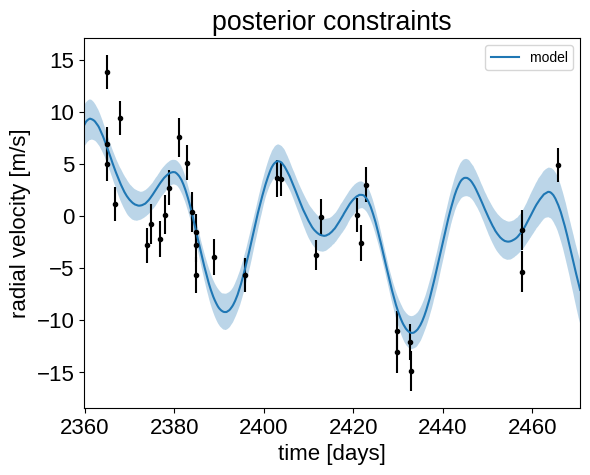

In [13]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

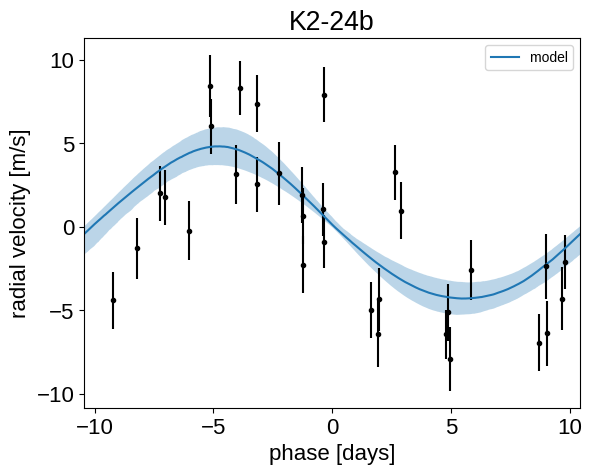

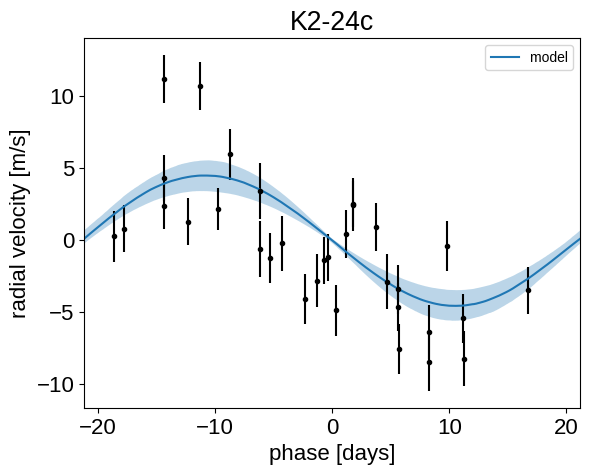

In [14]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["P"].values[:, :, n])
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [15]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{exoplanet:arviz,
exoplanet:astropy13, exoplanet:astropy18, exoplanet:pymc3, exoplanet:theano,
exoplanet:vaneylen19}.


In [16]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System